<a href="https://colab.research.google.com/github/lsteffenel/M2Atmo_et_Climat/blob/main/07b-MNIST_regression_avec_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Construire un modèle de réseaux de neurones dense (DNN) avec Keras pour la régression

Nous avons déjà vu comment utiliser un réseau dense avec Keras pour la classification du dataset MNIST. Une variante de cet exercice est celui de construire un réseau pour la régression : au lieu de prédire la classe d'une image, nous allons essayer d'obtenir une valeur proche de celle du "label" associée à l'image.

Cet exemple est, bien sûr, très naïf car les prédictions seront difficilement exactes. Mais c'est un exemple qui peut s'appliquer à d'autres datasets, comme par exemple essayer de prédire le niveau de précipitation à partir d'une image radar.

Dans les prochains paragraphes vous trouverez presque toutes les commandes déjà utilisées pour l'exemple de classification. Faites attention aux modifications qui ont été faites pour transformer le problème en régression.

In [2]:
import tensorflow as tf

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np
print (tf.__version__)
print(keras.__version__)


2.17.1
3.5.0


## Chargement de données

Tout comme Scikit-Learn, Keras a aussi un ensemble de datasets prêt à utilisation pour des exemples. Dans le cas suivant, nous allons charger le dataset MNIST (écriture à la main) et le séparer en deux groupes : Train et Test. Les données de validation (vérification pendant l'entraînement) seront séparés du groupe Train plus tard.

In [3]:
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
x_train.shape
x_test.shape
y_test.shape

(10000,)

In [5]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Les données de MNIST se présentent sous la forme d'images 28x28 pixels, avec 256 tons de gris. Les labels (`y_train`, par exemple) correspondent aux caractères représentés : les chiffres 0 à 9.

Le paragraphe suivant définit une fonction permettant de visualiser ce dataset.

In [6]:
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos', save_as='auto'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3),(-1,1,lx,ly) or (-1,3,lx,ly)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns:
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    # Torch Tensor ?
    if y.__class__.__name__      == 'Tensor': y=y.numpy()
    if y_pred.__class__.__name__ == 'Tensor': y_pred=y_pred.detach().numpy()

    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,c) or (c,lx,ly)
        if len(x[i].shape)==3:
            if x[i].__class__.__name__ == 'Tensor':
               (c,lx,ly)=x[i].shape
               if c==1:
                   xx=x[i].permute(1,2,0).numpy().reshape(lx,ly)
               else:
                   xx=x[i].permute(1,2,0).numpy() #---> (lx,ly,n)
            else:
                (lx,ly,c)=x[i].shape
                if c==1:
                    xx=x[i].reshape(lx,ly)
                else:
                    xx=x[i]

        img=axs.imshow(xx,   cmap = cm, norm=norm, interpolation=interpolation)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    plt.show()



Nous allons donc afficher l'un des caractères du groupe Train (celui à la position 27) mais aussi tout la plage entre les données 5 et 41. Remarquez le "label" correspondant sous chaque image.

3


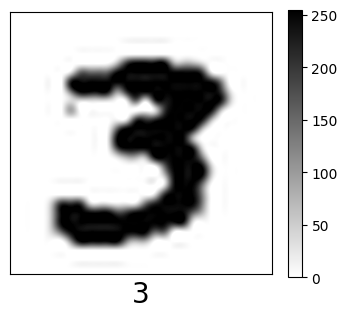

In [7]:
print(y_train[27])
plot_images(x_train, y_train, indices=[27],  x_size=5,y_size=5, colorbar=True)


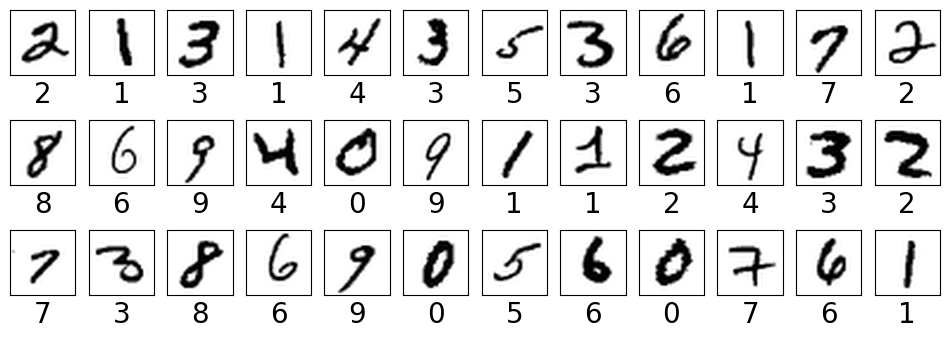

In [8]:
plot_images(x_train, y_train, range(5,41), columns=12)

**1 - Normalisation des données**

Les valeurs de base son des entiers entre 0 et 255 pour représenter les 256 tons de gris. La majorité des algorithmes utilisent des valeurs réels, de préférence dans la fourchette 0 à 1 ou -1 à 1.

Les paragraphes suivantes modifient le type des données (`float32`) puis font une normalisation simple (diviser la valeur par `max`, qui dans ce cas doît être de 255). Bien sûr, d'autres méthodes de normalisation plus élaborées sont possibles, mais ça suffit pour l'instant.

In [28]:
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')
y_train = y_train.astype('float16')
y_test = y_test.astype('float16')

In [29]:
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

xmax=x_train.max()
x_train = x_train / xmax
x_test  = x_test  / xmax

print('After normalization  : Min={}, max={}'.format(x_train.min(),x_train.max()))

Before normalization : Min=0.0, max=1.0
After normalization  : Min=0.0, max=1.0


**3 - Labels**

Contrairement à l'exemple de classification, cette fois-ci nous utiliserons les labels comme de valeurs cible à estimer.

## La Création d'un modèle

Keras a plusieurs modes permettant la création de modèles de réseaux de neurones. Dans ce cas, nous allons utiliser l'API `Sequential` qui permet de décrire couche par couche du réseau et les empiler (grâce à `add()`).

Nous allons faire un modèle simple avec des réseaux denses (totalement connectés). La première couche définit la taille de l'entrée (les 784 valeurs reçus du dataset), les autres utilisent par défaut la taille de la sortie de la couche précédente.

La différence est que nous utiliserons un seul neurone en sortie, avec l'activation "Linear". Cela veut dire que nous allons simplement obtenir la valeur pondérée des neurones, au lieu d'avoir une liste de probabilités pour 10 classes.

In [30]:
from keras import Sequential
from keras import layers
from keras import optimizers

# Declaration du modèle en Keras
model = keras.Sequential()
model.add(layers.Input((28,28)))
model.add(layers.Flatten())
model.add(layers.Dense(30, activation='sigmoid'))
model.add(layers.Dense(20, activation='sigmoid'))
model.add(layers.Dense(1, activation='linear'))


# résumé du modèle
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │          23,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,191 (94.50 KB)

 Trainable params: 24,191 (94.50 KB)

 Non-trainable params: 0 (0.00 B)

## Entraînement du modèle

Une fois défini le modèle, il faut l'entraîner avec les données.
Le paragraphe suivant définit les hyperparamètres du modèle, dont le `batch_size`(taille des sous-ensembles utilisés dans la descente de gradient), le nombre d'epochs (parcours de l'ensemble de données d'entraînement).

L'appel à compile génère le graphe d'exécution (un réseau de neurones = un graphe) et indique aussi qu'on utilise le modèle de descente de gradient SGD, que la métrique utilisée est l'accuracy (métrique qui correspond à (TP+TN)/(TP+TN+FP+FN)), et que la fonction de perte est la `categorical_crossentropy`, une fonction qui compare les probabilités pour des labels catégoriques.

In [31]:
batch_size = 100
#num_classes = 10
epochs= 20

model.compile(loss='mse',  optimizer='Adam',  metrics=['mse'])


Finalement, on lance l'entraînement. Remarquez aussi qu'on n'a pas crée des données Validation avant, on le fera **sur place** en réservant 10% des données de Train (appel à `validation_split=0.1`).

Comme le dataset est simple, on peut faire l'entraînement même sans un GPU.

In [32]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,verbose=1 )

#verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
# Je vous invite à lire la documentation : https://keras.io/models/sequential/

Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.0535 - mse: 9.0535 - val_loss: 2.9802 - val_mse: 2.9802
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9340 - mse: 2.9340 - val_loss: 1.8412 - val_mse: 1.8412
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9291 - mse: 1.9291 - val_loss: 1.3474 - val_mse: 1.3474
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4585 - mse: 1.4585 - val_loss: 1.0726 - val_mse: 1.0726
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2225 - mse: 1.2225 - val_loss: 0.9723 - val_mse: 0.9723
Epoch 6/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0839 - mse: 1.0839 - val_loss: 0.8692 - val_mse: 0.8692
Epoch 7/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9749 - mse: 0.9749 - val_loss: 0.8202 - val_mse: 0.8202
Epoch 8/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9252 - mse: 0.9252 - val_loss: 0.7880 - val_mse: 0.7880
Epoch 9/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

Les paragraphes suivants nous permettent de voir comment le modèle améliore sa performance au fil des epochs

In [18]:
def plot_history(history, figsize=(8,6),
                 plot={"Accuracy":['mse','val_mse'], 'Loss':['loss', 'val_loss']}):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')

        plt.show()

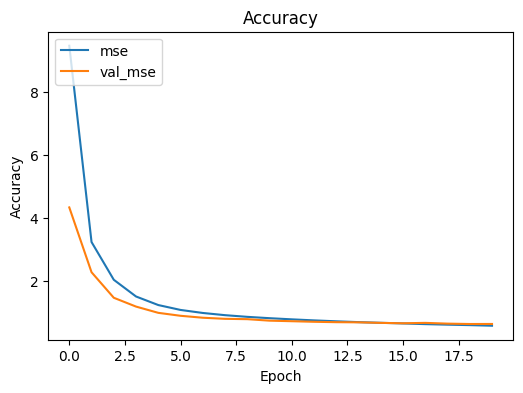

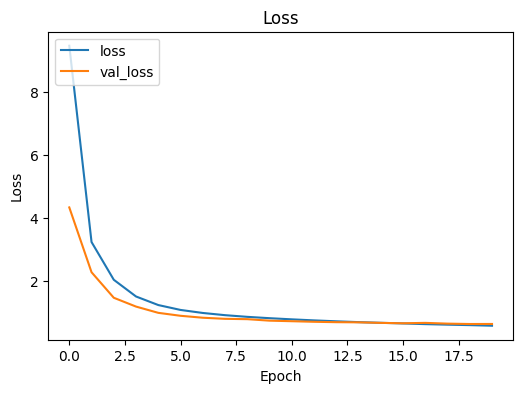

In [19]:
plot_history(history, figsize=(6,4))

Enfin, on peut estimer la performance du modèle avec les données Test.

Comparez ces valeur avec ceux de l'entraînement (`val_loss` et `val_mse`
 ci-dessus). Comme la métrique MSE est "le carré de l'erreur", on fait également la RMSE pour avoir une idée de l'erreur moyenne sur les estimations.

In [34]:
import math
test_loss, test_mse = model.evaluate(x_test, y_test,verbose=0)

print('Test loss:', test_loss)
print('Test mse:', test_mse)
print('Test rmse:', math.sqrt(test_mse))

Test loss: 0.7845431566238403
Test mse: 0.7845431566238403
Test rmse: 0.8857444081809607


Ces résultats montrent que, étonemment, le modèle se porte mieux avec le groupe de validation (val_accuracy), c'est intéressant 👍.

## Quelques erreurs

Si vous avez fait attention, on n'a toujours pas touché le dataset `x_test/y_test`, vu qu'on a fait l'entraînement avec 90% et validé avec 10% du x_train.

On peut donc utiliser x_test comme "nouvelle donnée" et vérifier si notre modèle rend bien les réponses.

Dans le prochain paragraph, nous allons donc produire une estimation `y_pred` à partir de `x_test`. La sortie du modèle est une valeur réelle, qui sera au pire "proche" de la valeur de l'image.

In [35]:
# d'abord, on utilise le modèle pour faire une prévision sur l'ensemble de test
# Ça retourne une liste avec 10 colonnes (une par sortie possible).
y_pred = model.predict(x_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Maintenant, on affiche quelques éléments, avec la valeur prédite et la valeur attendue (entre parenthèses). Au delà de l'erreur d'approximation (ex : 1.244 pour un 1), on trouve également des erreurs d'identification (sur la dernière ligne il y a un 9 qui a été incorrectement identifié comme un 7).

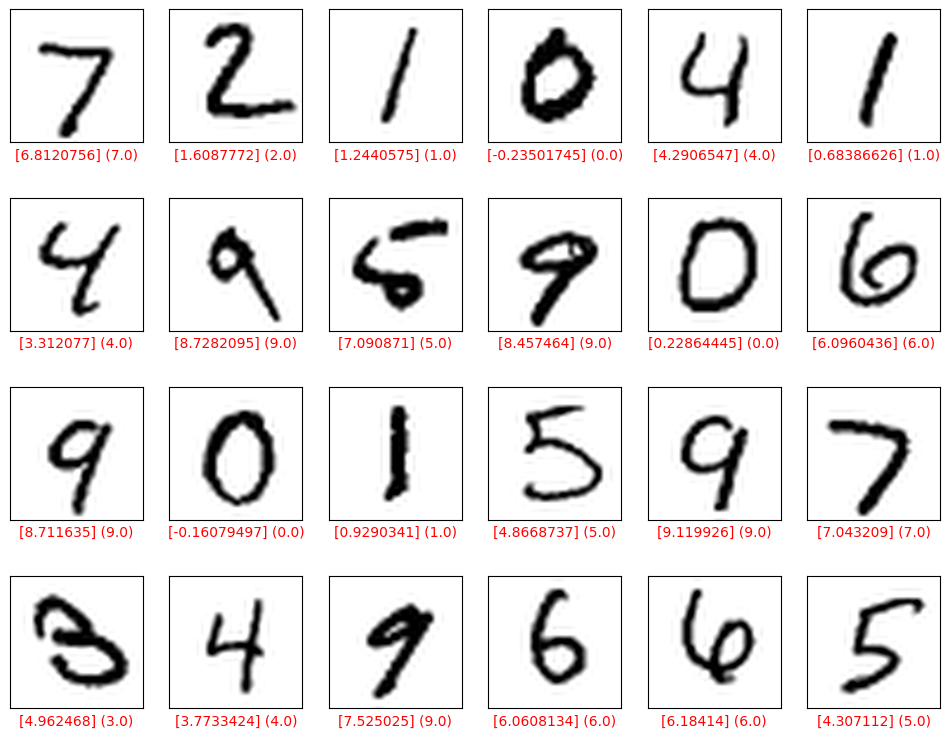

In [38]:


plot_images(x_test, y_test, range(0,24), columns=6, x_size=2, y_size=2, y_pred=y_pred,fontsize=10)

## Exercice :
Essayez de réduire l'erreur. Comme pour la classification, changez les fonctions d'activation, le nombre de neurones, le nombre de couches...

